# ESDA with rgeoda and sp

For people who using R to do spatial data analysis, a common routine is to use `rgdal` package to read spatial dataset, and then use `sp` package, or (in recent) `sf` package, to handle and analyze spatial data and plot the results on maps.

rgeoda provides utility functions to create a `geoda` instance from an `sp` object or `sf` object, so that users can easily integrate the functions of spatial data analysis in rgeoda into their existing work.

In this note, we will work with `sp` and `rgeoda` package to do exploratory spatial data analysis (ESDA).

## Start from sp package

The sp package has been an essential tool which provides spatial data-structures and many utility functions to do spatial analysis in R. It has been a core dependent library for many other packages, e.g. rgdal (IO), maptools (mapping), spdep (spatial weights, spatial statistics, and spatial models) etc.

Using rgdal to read a ESRI Shapefile will return a sp (Spatial object) object, which could be either a SpatialPointsDataFrame (using an AttributeList for its data slot directly), a SpatialLinesDataFrame, or a SpatialPolygonsDataFrame.

In [1]:
# use the Guerry.shp comes with the rgeoda package
guerry_path <- system.file("extdata", "Guerry.shp", package = "rgeoda")

# load rgdal library which sp is working with
library(rgdal)

Loading required package: sp
rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.1, released 2019/03/15
 Path to GDAL shared files: /usr/local/Cellar/gdal/2.4.1_1/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


Note: to install rgdal library in R, you can run: install.packages('rgdal')


Then, we can call `readOGR()` function to read Guerry.shp file and this function will returns an `sp` object

In [2]:
guerry_sp <- readOGR(guerry_path)


OGR data source with driver: ESRI Shapefile 
Source: "/usr/local/lib/R/3.6/site-library/rgeoda/extdata/Guerry.shp", layer: "Guerry"
with 85 features
It has 26 fields
Integer64 fields read as strings:  dept Crm_prs Crm_prp Litercy Donatns Infants Suicids MainCty Wealth Commerc Clergy Crm_prn Infntcd Dntn_cl Lottery Desertn Instrct Prsttts Area 


You can simply call plot() function to plot this map:

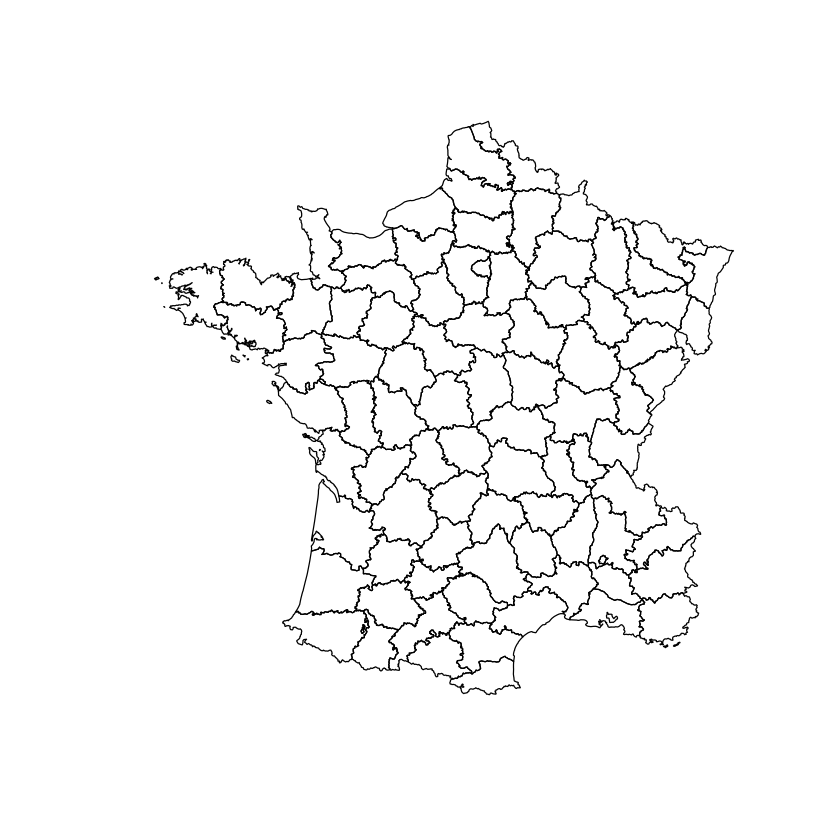

In [3]:
plot(guerry_sp)

## Create rgeoda object from sp

Everything above should be very familiar with you, right? Then, the fun part of spatial data analysis is going to start:

Create a geoda object from the sp object guerry_sp you just created.

In [4]:
library(rgeoda)

guerry <- sp_to_geoda(guerry_sp)

Loading required package: wkb


That’s it! It should be very fast: rgeoda uses `wkb`, which is a binary representation of geometries, to exchange data between sp and rgeoda in memory.

Note: by default, sp_to_geoda() only using geometries to create a geoda object, which is fast and user can reuse the data.frame from the sp object to do analysis. This function has an optional parameter `with_table`, to allow user to use both geometries and data.frame to create a geoda object by calling, for example: sp_to_geoda(guerry_sp, with_table=TRUE)

## ESDA with rgeoda

Now, with the rgeoda object `guerry`, you can call rgeoda’s spatial analysis functions easily. For example, to examine the local Moran statistics of variable “crm_prs” (Population per Crime against persons):



In [5]:
queen_w <- queen_weights(guerry)
crm_prp <- as.numeric(as.character(guerry_sp$Crm_prp))

```
Note: Why are we using `as.numeric(as.character(guerry_sp$Crm_prp))`?

As we can see from the output of `readOGR(guerry_path)` that: _"Integer64 fields read as strings:  dept Crm_prs Crm_prp Litercy Donatns Infants Suicids MainCty_", so `guerry_sp$Crm_prp` is with data type `factor`, so `as.numeric(as.character())` is used to convert it to a column with numeric values without lossing precisions.
```

### Local Moran Map




In [6]:
lisa <- local_moran(queen_w, crm_prp)


Now, with the LISA results, we can do exploratory spatial data analysis by generating a LISA cluster map:


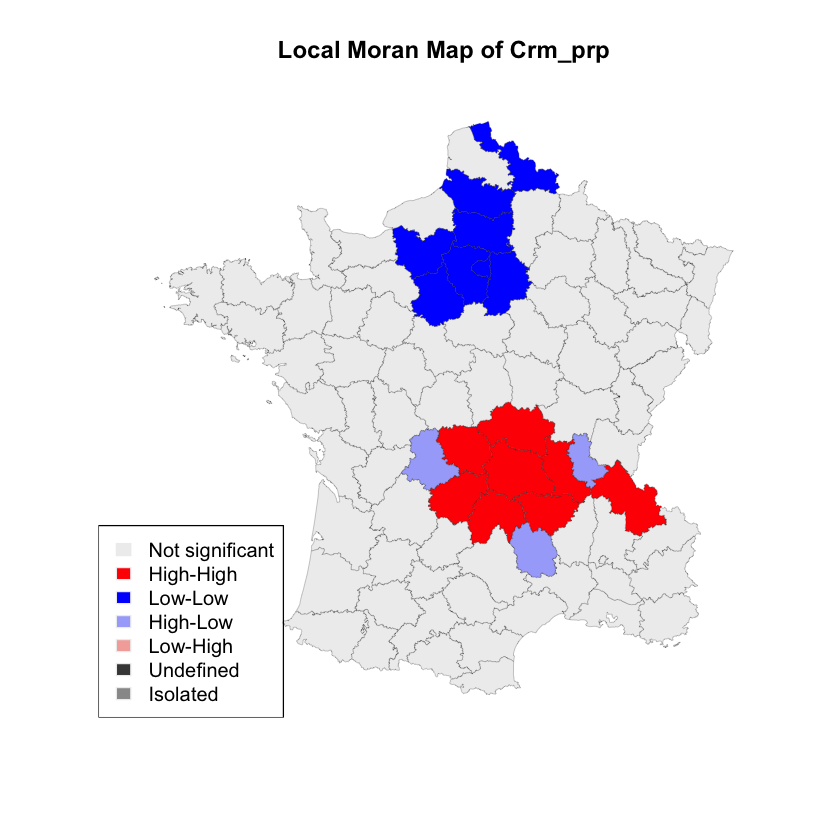

In [7]:
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

From the above code, you can see that we still use `sp` object to do plotting. The values of cluster indicators from rgeoda’s `LISA` object are used to make the LISA map.This emphasis that rgeoda is a API focused library, which only provides the core functions of spatial data analysis for easy integration.

You can easily append the lisa results to original sp object by manipulating the data.frame object inside the sp object.

In [8]:
guerry_sp$moran_cluster <- lisa_clusters

If you check the values of the cluster indicators, you will see they are integer numbers 0 (not significant), 1 (high-high cluster), 2 (low-low cluster), 3 (low-high cluster), 4 (high-low cluster), 5 (neighborless/island), 6 (undefined), which are excatly the same with GeoDa software when you save LISA results to a table:

In [9]:
lisa_clusters

[1] 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 0
[39] 0 1 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 2 2 0 0 1 0 0 0 0 0 3 0 0 0 2 0 2 2 0 2
[77] 0 0 0 0 0 0 3 0 0

To create a siginificant map that is associated with the Local Moran map:


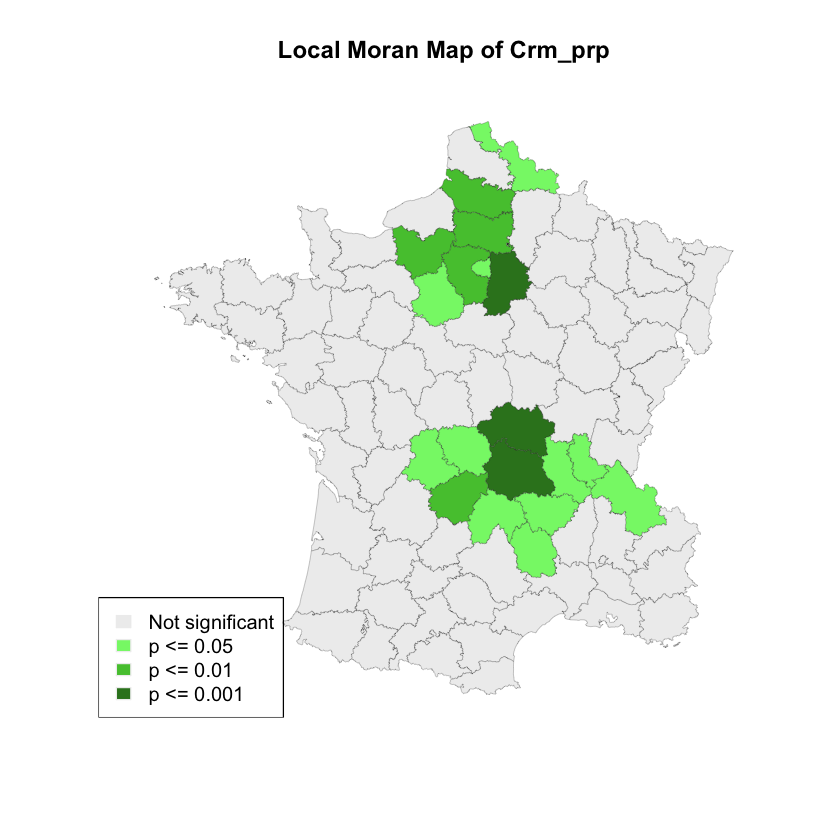

In [10]:
lisa_p <- lisa$GetPValues()
p_labels <- c("Not significant", "p <= 0.05", "p <= 0.01", "p <= 0.001")
p_colors <- c("#eeeeee", "#84f576", "#53c53c", "#348124")
plot(guerry_sp, 
     col=sapply(lisa_p, function(x){
       if (x <= 0.001) return(p_colors[4])
       else if (x <= 0.01) return(p_colors[3])
       else if (x <= 0.05) return (p_colors[2])
       else return(p_colors[1])
       }), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map of Crm_prp")
legend('bottomleft', legend = p_labels, fill = p_colors, border = "#eeeeee")

### Local Geary Map

Another example is to create a map of local Geary:

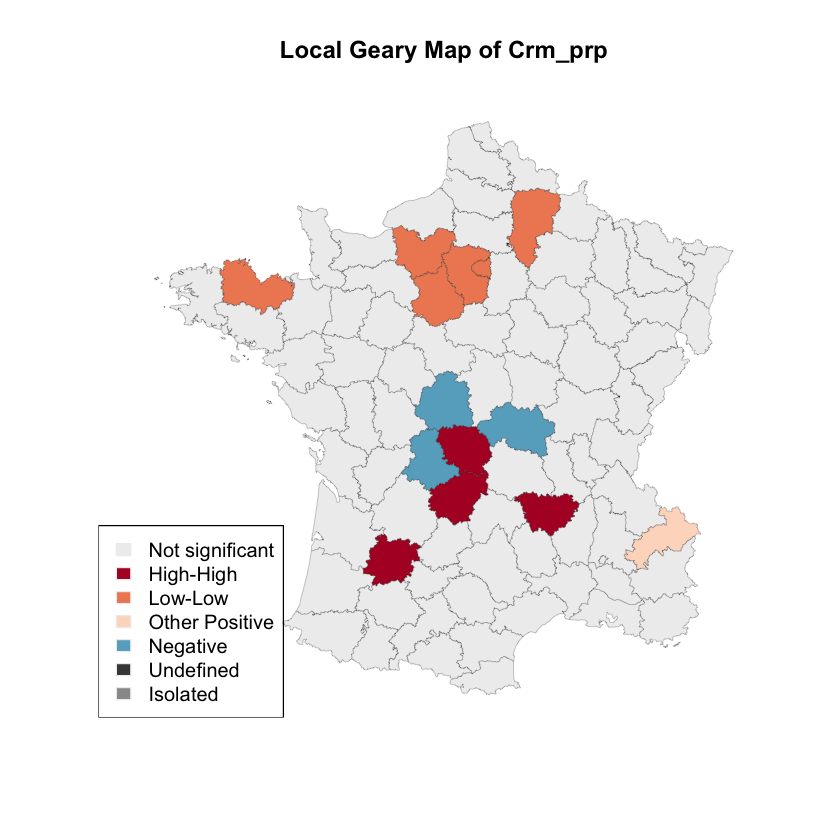

In [11]:
lisa <- local_geary(queen_w, crm_prp)
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Geary Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### Local G Map

To create a map of local G:

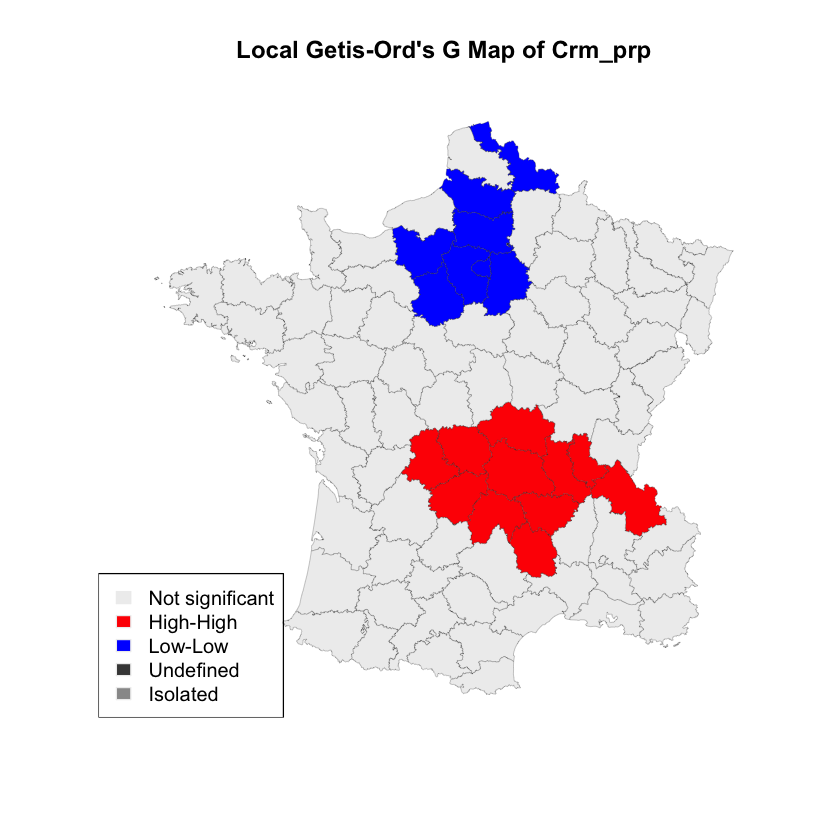

In [12]:
lisa <- local_g(queen_w, crm_prp)
lisa_colors <- lisa$GetColors() 
lisa_labels <- lisa$GetLabels()
lisa_clusters <- lisa$GetClusterIndicators()

plot(guerry_sp, 
     col=sapply(lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Getis-Ord's G Map of Crm_prp")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

### SKATER Map

To create a map of SKATER clustering map:

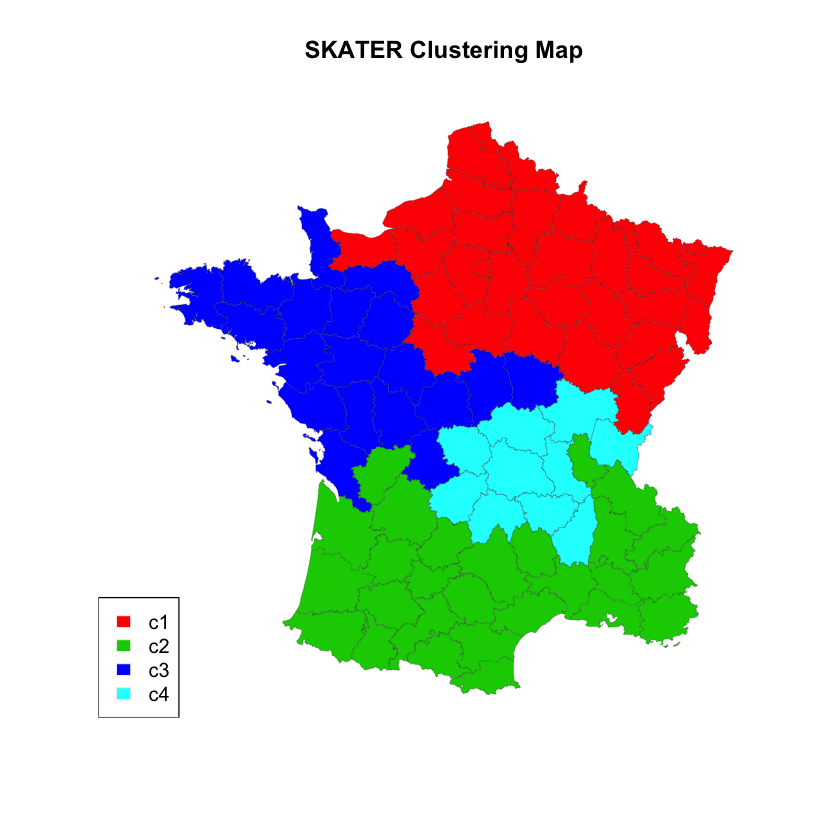

In [13]:
Crm_prp <- as.numeric(as.character(guerry_sp$Crm_prp))
Litercy <- as.numeric(as.character(guerry_sp$Litercy))
Donatns <- as.numeric(as.character(guerry_sp$Donatns))
Infants <- as.numeric(as.character(guerry_sp$Infants))
Suicids <- as.numeric(as.character(guerry_sp$Suicids))
data <- list(crm_prp, Crm_prp, Donatns, Infants, Suicids)
guerry_clusters <- skater(4, queen_w, data)

# Get some colors for each clusters
skater_colors <- palette()[2:5]
skater_labels <- c("c1","c2","c3","c4")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:4) {
  for (j in guerry_clusters[i]) {
    colors[j+1] <- skater_colors[i]
  }
}

# plot
plot(guerry_sp,  col=colors, border = "#333333", lwd=0.2)
title(main = "SKATER Clustering Map")
legend('bottomleft', legend = skater_labels, fill = skater_colors, border = "#eeeeee")

### Max-p Clustering Map

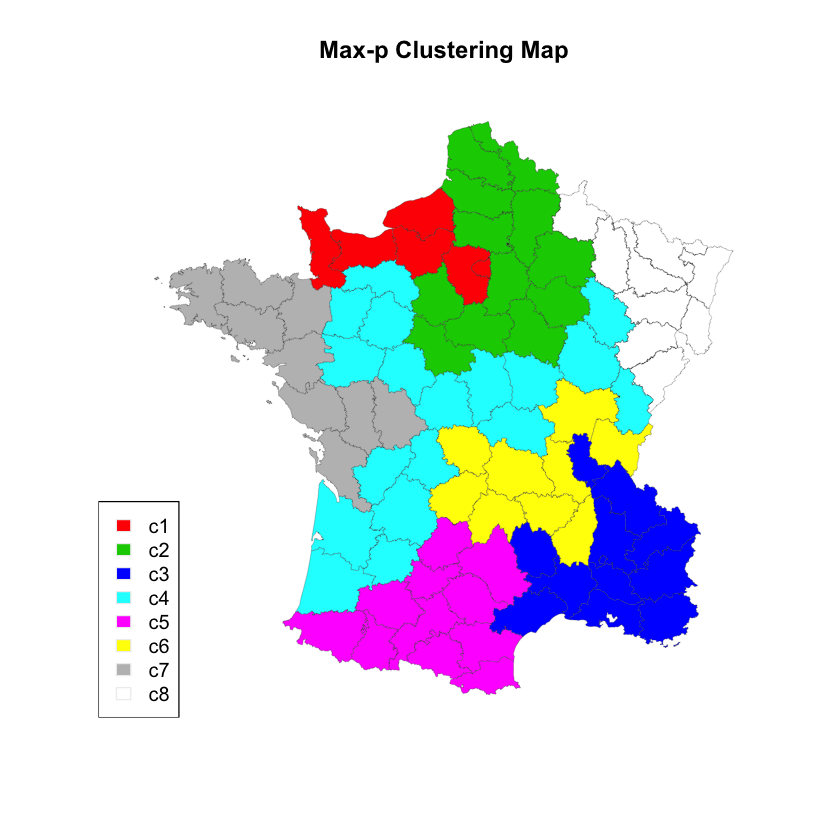

In [14]:
bound_vals <- as.numeric(guerry_sp$Pop1831)
min_bound <- 3236.67 # 10% of Pop1831

maxp_clusters <- maxp(queen_w, data, bound_vals, min_bound, "greedy")

# Get some colors for each clusters
maxp_colors <- palette()[2:10]
maxp_labels <- c("c1","c2","c3","c4","c5","c6","c7","c8")

# Assign a color for each observation
colors <- rep("#000000", queen_w$num_obs)
for (i in 1:8) {
  for (j in maxp_clusters[i]) {
    colors[j+1] <- maxp_colors[i]
  }
}

# plot
plot(guerry_sp,  col=colors, border = "#333333", lwd=0.2)
title(main = "Max-p Clustering Map")
legend('bottomleft', legend = maxp_labels, fill = maxp_colors, border = "#eeeeee")